## Preentrenamiento - Weiss

#### Lectura de datasets

In [1]:
import re

class Dataset:
    
    def clean_str(self, string):
        """
        Tokenization/string cleaning for all datasets except for SST.
        Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
        """
        string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
        string = re.sub(r"\'s", " \'s", string)
        string = re.sub(r"\'ve", " \'ve", string)
        string = re.sub(r"n\'t", " n\'t", string)
        string = re.sub(r"\'re", " \'re", string)
        string = re.sub(r"\'d", " \'d", string)
        string = re.sub(r"\'ll", " \'ll", string)
        string = re.sub(r",", " , ", string)
        string = re.sub(r"!", " ! ", string)
        string = re.sub(r"\(", " \( ", string)
        string = re.sub(r"\)", " \) ", string)
        string = re.sub(r"\?", " \? ", string)
        string = re.sub(r"\s{2,}", " ", string)

        return string.strip().lower()
    
    #################################################################
    ##################### 20 Newsgroups #############################
    #################################################################
    
    path_train_20newsgroups = "../20NewsGroup/20ng-train-stemmed.txt"
    path_test_20newsgroups = "../20NewsGroup/20ng-test-stemmed.txt"
    
    target_names_20newsgroups = [
        "alt.atheism", 
        "comp.graphics",
        "comp.os.ms-windows.misc",
        "comp.sys.ibm.pc.hardware", 
        "comp.sys.mac.hardware",
        "comp.windows.x",
        "misc.forsale",
        "rec.autos",
        "rec.motorcycles",
        "rec.sport.baseball",
        "rec.sport.hockey",
        "sci.crypt",
        "sci.electronics",
        "sci.med",
        "sci.space",
        "soc.religion.christian",
        "talk.politics.guns",
        "talk.politics.mideast",
        "talk.politics.misc",
        "talk.religion.misc"
    ]
    
    def read_20newsgroups_file(self, path_test_20newsgroups):
        data = []
        target = []
        
        with open(path_test_20newsgroups) as file:
            for index, line in enumerate(file):
                tokens_count = len(line.split())

                if tokens_count > 1 and tokens_count <= 301:
                    category, text = line.split(None, 1)
                    data.append(self.clean_str(text))
                    target.append(self.target_names_20newsgroups.index(category))
                
        return data, target
        
    
    def fetch_20newsgroups(self, subset = "train"):
        dataset = {'data': None,  'target': None , 'target_names': self.target_names_20newsgroups}
    
        if subset == 'train':
            dataset['data'], dataset['target'] = self.read_20newsgroups_file(self.path_train_20newsgroups)
        elif subset == 'test':
            dataset['data'], dataset['target'] = self.read_20newsgroups_file(self.path_test_20newsgroups)
        elif subset == 'all':
            data_train, target_train = self.read_20newsgroups_file(self.path_train_20newsgroups)
            data_test, target_test = self.read_20newsgroups_file(self.path_test_20newsgroups)
            
            dataset['data'], dataset['target'] = data_train + data_test, target_train + target_test
        
        return dataset
    
    #################################################################
    ##################### SearchSnippets ############################
    #################################################################
    
    path_train_search_snippets = "../SearchSnippets/train.txt"
    path_test_search_snippets = "../SearchSnippets/test.txt"
    
    target_names_search_snippets = [
        "business",
        "computers",
        "culture-arts-entertainment",
        "education-science",
        "engineering",
        "health",
        "politics-society",
        "sports"
    ]
    
    def read_search_snippets_file(self, path_test_search_snippets):
        data = []
        target = []
        
        with open(path_test_search_snippets, encoding="utf8") as file:
            for index, line in enumerate(file):
                tokens_count = len(line.split())
               
                if tokens_count > 1 and tokens_count <= 301:
                    text, category = line.rsplit(None, 1)
                    data.append(self.clean_str(text))
                    target.append(self.target_names_search_snippets.index(category))
                
        return data, target
        
    
    def fetch_search_snippets(self, subset = "train"):
        dataset = {'data': None,  'target': None , 'target_names': self.target_names_search_snippets}
    
        if subset == 'train':
            dataset['data'], dataset['target'] = self.read_search_snippets_file(self.path_train_search_snippets)
        elif subset == 'test':
            dataset['data'], dataset['target'] = self.read_search_snippets_file(self.path_test_search_snippets)
        elif subset == 'all':
            data_train, target_train = self.read_search_snippets_file(self.path_train_search_snippets)
            data_test, target_test = self.read_search_snippets_file(self.path_test_search_snippets)
            
            dataset['data'], dataset['target'] = data_train + data_test, target_train + target_test
        
        return dataset

#### Métodos de Preentrenamiento

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from pprint import pprint
import numpy as np
import threading
import math as mt
import multiprocessing
import time

class binaryCodes:
    
    vectorizer = TfidfVectorizer()
    
    def __init__(self, dataset, sigma = 2, method = 'weiss', k_neighbors = 7, c_coeff = 1, 
                 a_equal_coeff = 1, b_unequal_coeff = 0.1):
        self.tf_idf_features_matrix = self.tf_idf(dataset['data'])
        self.distance_matrix = self.euclidean_distance(self.tf_idf_features_matrix)
        self.labels = dataset['target']
        self.sigma = sigma
        self.method = method
        self.k_neighbors = k_neighbors
        self.c_coeff = c_coeff
        self.a_equal_coeff = a_equal_coeff
        self.b_unequal_coeff = b_unequal_coeff
        
    def tf_idf(self, data):
        return self.vectorizer.fit_transform(data)
    
    def euclidean_distance(self, tf_idf_features):
        return euclidean_distances(tf_idf_features, tf_idf_features)
    
    def parallel_operation(self, row_interval, w):
        for row in range(row_interval[0], row_interval[1]):
            for column in range(row, w.shape[1]):
                
                if self.method == 'weiss':
                    value = np.exp(-self.distance_matrix[row][column]**2/self.sigma**2)
                    
                elif self.method == 'chinese_weiss':
                  
                    row_neighbors = self.distance_matrix[row].argsort()[1:self.k_neighbors+1]
                    column_neighbors = self.distance_matrix[column].argsort()[1:self.k_neighbors+1]
                    
                    if row in column_neighbors or column in row_neighbors:
                        value = self.c_coeff*np.exp(-self.distance_matrix[row][column]**2/(2*self.sigma**2))
                    else:
                        value = 0
                        
                elif self.method == 'chinese_weiss_supervised':
                    
                    row_neighbors = self.distance_matrix[row].argsort()[1:self.k_neighbors+1]
                    column_neighbors = self.distance_matrix[column].argsort()[1:self.k_neighbors+1]
                    
                    if row in column_neighbors or column in row_neighbors:
                        if self.labels[row] == self.labels[column]:
                            value = self.a_equal_coeff*np.exp(-self.distance_matrix[row][column]**2/(2*self.sigma**2))
                        else:
                            value = self.b_unequal_coeff*np.exp(-self.distance_matrix[row][column]**2/(2*self.sigma**2))
                    else:
                        value = 0
                    
                w[row, column] = value
                
                if row != column:
                    w[column, row] = value
        
    def parallel_operation2(self, row_interval, w_matrix, d):
        for row in range(row_interval[0], row_interval[1]):
            sum_row = np.sum(w_matrix[row])
            d[row, row] = sum_row
                
    def w_matrix(self):
        
        print("Calculating W matrix using {} method ...".format(self.method))
        
        data_size, _ = self.tf_idf_features_matrix.shape

        start_time = time.time()

        w = np.zeros((data_size, data_size))

        cores_count = multiprocessing.cpu_count()
        bounds = list(range(mt.floor(data_size/cores_count), 
                            data_size-data_size%cores_count+1, mt.floor(data_size/cores_count)))

        bounds[-1] += data_size%cores_count

        threads = list()

        lower_bound = 0

        for index, upper_bound in enumerate(bounds):
            threads.append(threading.Thread(target = self.parallel_operation, args=([lower_bound, upper_bound], w)))
            lower_bound = upper_bound

        for thread in threads:
            thread.start()

        for thread in threads:
            thread.join()

        elapsed_time = time.time() - start_time

        print("Time to compute: {} min".format(elapsed_time/60))

        print("Nonzero elements count: {}".format(np.count_nonzero(w)))
        print("Ratio: {}".format(np.count_nonzero(w)/data_size**2))

        return w
    
    def d_matrix(self, w_matrix):
        
        print("Calculating D matrix using {} method ...".format(self.method))
        
        data_size, _ = self.tf_idf_features_matrix.shape
        
        start_time = time.time()
        
        d = np.zeros((data_size, data_size))

        cores_count = multiprocessing.cpu_count()
        bounds = list(range(mt.floor(data_size/cores_count), 
                            data_size-data_size%cores_count+1, mt.floor(data_size/cores_count)))

        bounds[-1] += data_size%cores_count

        threads = list()

        lower_bound = 0

        for index, upper_bound in enumerate(bounds):
            threads.append(threading.Thread(target = self.parallel_operation2, 
                                            args=([lower_bound, upper_bound], w_matrix, d)))
            lower_bound = upper_bound
            
        for thread in threads:
            thread.start()

        for thread in threads:
            thread.join()

        elapsed_time = time.time() - start_time
        
        print("Time to compute: {} min".format(elapsed_time/60))

        return d
    
    def binary_codes(self, hash_len = 64):
        
        data_size, _ = self.tf_idf_features_matrix.shape
        sigma_str = str(self.sigma).replace('.', '')
        c_coeff_str = str(self.c_coeff).replace('.', '')
        a_equal_coeff_str = str(self.a_equal_coeff).replace('.', '')
        b_unequal_coeff_str = str(self.b_unequal_coeff).replace('.', '')
        
        try:
            hash_codes = np.load('hash_codes-{}_{}_{}_{}_{}_{}_{}_{}.npy'.format(data_size, hash_len, self.method, 
                                     sigma_str, c_coeff_str, a_equal_coeff_str, b_unequal_coeff_str, self.k_neighbors))    
            
            print("Using preexisting hash codes")

        except:
        
            print("Calculating hash codes")
            global_start_time = time.time()
            
            try:
                eigen_values = np.load('eigen_values-{}_{}_{}_{}_{}_{}_{}.npy'.format(data_size, self.method, sigma_str, 
                                                        c_coeff_str, a_equal_coeff_str, b_unequal_coeff_str, self.k_neighbors)) 
                eigen_vectors = np.load('eigen_vectors-{}_{}_{}_{}_{}_{}_{}.npy'.format(data_size, self.method, sigma_str, 
                                                        c_coeff_str, a_equal_coeff_str, b_unequal_coeff_str, self.k_neighbors))
                
                print("Using preexisting eigen vectors and values")
                
            except:
                
                w_matrix = self.w_matrix()
                d_matrix = self.d_matrix(w_matrix)

                sub_martix = d_matrix-w_matrix
                
                print("Calculating eigen vectors")
                
                eigen_values, eigen_vectors = np.linalg.eig(sub_martix)
                
                np.save('eigen_values-{}_{}_{}_{}_{}_{}_{}.npy'.format(data_size, self.method, sigma_str, 
                                        c_coeff_str, a_equal_coeff_str, b_unequal_coeff_str, self.k_neighbors), eigen_values)
                
                np.save('eigen_vectors-{}_{}_{}_{}_{}_{}_{}.npy'.format(data_size, self.method, sigma_str, 
                                        c_coeff_str, a_equal_coeff_str, b_unequal_coeff_str, self.k_neighbors), eigen_vectors)

            eigen_values = np.delete(eigen_values, 0)
            eigen_vectors = np.delete(eigen_vectors, 0, 1)

            min_eigen_values = np.argsort(eigen_values)
           
            count = 0
            hash_codes = list()

            for i in range(hash_len):
                min_eigen_values[count]
                hash_codes.append(eigen_vectors[:, min_eigen_values[count]])
                count += 1

            hash_codes = np.asarray(hash_codes).transpose()

            threshold = lambda x: 1 if x>=0 else 0 
            vfunc = np.vectorize(threshold)

            hash_codes = vfunc(hash_codes)

            elapsed_time = time.time() - global_start_time

            print("Total Time: {} min \n".format(elapsed_time/60))

            np.save('hash_codes-{}_{}_{}_{}_{}_{}_{}_{}.npy'.format(data_size, hash_len, self.method, 
                        sigma_str, c_coeff_str, a_equal_coeff_str, b_unequal_coeff_str, self.k_neighbors), hash_codes)
        
        return hash_codes

#### Evaluación mediante clusters

In [3]:
%matplotlib inline

from sklearn.neighbors import DistanceMetric
import ipython_genutils
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

class evaluate:
    
    def intra_cluster_distance(hash_codes, dataset):
        
        clusters = dict()
        
        categories = dataset['target']
        categories_names = dataset['target_names']
        
        for index, value in enumerate(categories):
            if value not in clusters.keys():
                clusters[value] = [hash_codes[index]]
            else:
                clusters[value].append(hash_codes[index])
                
        distance_matrix = DistanceMetric.get_metric('hamming')
        table = {'name': [], 'size': [], 'elements': [], 'median': [], 'mean': [], 'std': [], 'min': [], 'max': []}
        
        for label in clusters.keys():
            inner_distances = distance_matrix.pairwise(clusters[label])
            inner_distances = inner_distances[np.triu_indices(inner_distances.shape[0], 1)]
            
            table['name'].append(categories_names[label])
            table['size'].append(len(clusters[label]))
            table['elements'].append(len(inner_distances))
            table['median'].append(np.median(inner_distances))
            table['mean'].append(np.mean(inner_distances))
            table['std'].append(np.std(inner_distances))
            table['min'].append(np.amin(inner_distances))
            table['max'].append(np.amax(inner_distances))
            
        df = pd.DataFrame(data=table)
        display(df)
        display(df.describe()) 
        
        return inner_distances
    
    def inter_cluster_distance(hash_codes, dataset):
        
        clusters = dict()
        
        categories = dataset['target']
        categories_names = dataset['target_names']
        
        for index, value in enumerate(categories):
            if value not in clusters.keys():
                clusters[value] = [hash_codes[index]]
            else:
                clusters[value].append(hash_codes[index])
                
        distance_matrix = DistanceMetric.get_metric('hamming')
        table = {'name': [], 'size': [], 'elements': [], 'median': [], 'mean': [], 'std': [], 'min': [], 'max': []}
        
        pairs = list(itertools.combinations(clusters.keys(), 2))
        
        median_matrix = np.zeros((len(categories_names), len(categories_names)))
        mean_matrix = np.zeros((len(categories_names), len(categories_names)))
        std_matrix = np.zeros((len(categories_names), len(categories_names)))
        min_distance_matrix = np.zeros((len(categories_names), len(categories_names)))
        max_distance_matrix = np.zeros((len(categories_names), len(categories_names)))
        
        for label_a, label_b in pairs:
            inter_distances = distance_matrix.pairwise(clusters[label_a], clusters[label_b])
            median = np.median(inter_distances)
            mean = inter_distances.mean()
            std = inter_distances.std()
            min_distance = inter_distances.min()
            max_distance = inter_distances.max()
            
            median_matrix[label_a, label_b] = median
            median_matrix[label_b, label_a] = median
            
            mean_matrix[label_a, label_b] = mean
            mean_matrix[label_b, label_a] = mean
            
            std_matrix[label_a, label_b] = std
            std_matrix[label_b, label_a] = std
            
            min_distance_matrix[label_a, label_b] = min_distance
            min_distance_matrix[label_b, label_a] = min_distance
            
            max_distance_matrix[label_a, label_b] = max_distance
            max_distance_matrix[label_b, label_a] = max_distance
            
        ## Median
        df = pd.DataFrame(median_matrix, columns = categories_names, index = categories_names)
        fig, ax = plt.subplots(figsize=(12,10))
        
        plt.title("Median", fontsize=18)
        ttl = ax.title
        ttl.set_position([0.5, 1.01])
       
        sns.heatmap(df, annot=True, vmin=0, vmax=1, ax=ax)
        
        ## Mean
        df = pd.DataFrame(mean_matrix, columns = categories_names, index = categories_names)
        fig, ax = plt.subplots(figsize=(12,10))
        
        plt.title("Mean", fontsize=18)
        ttl = ax.title
        ttl.set_position([0.5, 1.01])
       
        sns.heatmap(df, annot=True, vmin=0, vmax=1, ax=ax)
        
        ## Std
        df = pd.DataFrame(std_matrix, columns = categories_names, index = categories_names)
        fig, ax = plt.subplots(figsize=(12,10))
        
        plt.title("Std", fontsize=18)
        ttl = ax.title
        ttl.set_position([0.5, 1.01])
       
        sns.heatmap(df, annot=True, vmin=0, vmax=0.1, ax=ax)
        
        ## Min distance
        df = pd.DataFrame(min_distance_matrix, columns = categories_names, index = categories_names)
        fig, ax = plt.subplots(figsize=(12,10))
        
        plt.title("Min Distance", fontsize=18)
        ttl = ax.title
        ttl.set_position([0.5, 1.01])
       
        sns.heatmap(df, annot=True, vmin=0, vmax=1, ax=ax)
        
        ## Max distance
        df = pd.DataFrame(max_distance_matrix, columns = categories_names, index = categories_names)
        fig, ax = plt.subplots(figsize=(12,10))
        
        plt.title("Max Distance", fontsize=18)
        ttl = ax.title
        ttl.set_position([0.5, 1.01])
       
        sns.heatmap(df, annot=True, vmin=0, vmax=1, ax=ax)
            
        return

#### Evaluación mediante infomation retrival

In [4]:
from sklearn.neighbors import DistanceMetric

class hashingDatabase:
    
    def __init__(self):
        self.database = []
        self.labels = []
    
    def add_element(self, element, label):
        self.database.append(element)
        self.labels.append(label)
        
    def find_neighbours_position(self, element):
        distance_metric = DistanceMetric.get_metric('hamming')
        distance_vector = distance_metric.pairwise([element], self.database)
        return np.argsort(distance_vector)
    
    def evaluate_P_K(self, element, label, k = None):
        neighbours_position = self.find_neighbours_position(element)[0][:k]
        matched = 0
        #print(neighbours_position)
        for neighbour_position in neighbours_position:
            #print('neighbor label: {}'.format(self.labels[neighbour_position]))
            if self.labels[neighbour_position] == label:
                matched += 1
        #print('precision {}'.format(matched/k))        
        return matched/k

### 20 Newsgroup

In [5]:
dataset = Dataset()
print("Dataset structure:")
train_dataset = dataset.fetch_20newsgroups(subset = 'train')
print(train_dataset.keys())
print("\n")
print("Dataset example:")
print(train_dataset['data'][0])
print("\n")
print("Train dataset:")
print("Set size: {}".format(len(train_dataset['data'])))
print("\n")

complete_dataset = train_dataset['data']

mean_length = sum(len(document.split()) for document in complete_dataset)/len(complete_dataset)
max_length = max(map(lambda document: len(document.split()), complete_dataset))

print('Mean Lenght: {}'.format(round(mean_length, 1)))
print('Max Lenght: {}'.format(max_length))
print("\n")

#vocabulary = list()
#for document in complete_dataset:
#    for word in document.split():
#        if word not in vocabulary:
#            vocabulary.append(word)
#
#print('Vocabulary Size: {}'.format(len(vocabulary)))

Dataset structure:
dict_keys(['data', 'target', 'target_names'])


Dataset example:
univers violat separ church state dmn kepler unh edu king becom philosoph philosoph becom king write recent ra order and resist care appar post religi flyer entitl soul scroll thought religion spiritu and matter soul insid bathroom stall door school univers hampshir sort newslett assembl hall director campu pose question spiritu each issu and solicit respons includ issu pretti vagu assum put christian care not mention jesu bibl heard defend doesn support religion thi state univers and strong support separ church and state enrag can thi sound scream for parodi give copi your friendli neighbourhood subgeniu preacher luck run mental mincer and hand you back outrag offens and gut bustingli funni parodi you can past origin can stool scroll thought religion spiritu and matter colon you can us thi text wipe mathew


Train dataset:
Set size: 10443


Mean Lenght: 94.3
Max Lenght: 300




### Weiss

#### Parametro $\epsilon$

#### 16 bits

In [7]:
import random
import copy
import math 

k = 100
sigma_parameters = [1, 2, 4, 8, 16, 32]
seeds = [1, 4 ,7]

precision_at_sigma_mean_16 = []
precision_at_sigma_std_16 = []

for sigma_parameter in sigma_parameters:
    print('Parametro epsilon {}'.format(sigma_parameter))
    hash_codes = binaryCodes(train_dataset, sigma=sigma_parameter, method = 'weiss')
    binary_codes = hash_codes.binary_codes(hash_len = 16)
    
    precision_val = []
    
    for count, seed in enumerate(seeds):
        print('    Conjunto de validacion {}'.format(count+1))
        random.seed(seed)
        
        validation_sample = random.sample(range(len(train_dataset['data'])), math.ceil(len(train_dataset['data'])*0.2))
        validation_split = {'binary_code': [], 'target': []}
        
        database = hashingDatabase()

        for index in range(len(train_dataset['data'])):
            if index in validation_sample:
                validation_split['binary_code'].append(binary_codes[index])
                validation_split['target'].append(train_dataset['target'][index])
            else:
                database.add_element(binary_codes[index], train_dataset['target'][index])

        precisions = []
        
        for index in range(len(validation_split['binary_code'])):
            precision = database.evaluate_P_K(validation_split['binary_code'][index], validation_split['target'][index], k)
            precisions.append(precision)    
            
        print("    --->Epsilon {} precision at {} mean precision {}".format(sigma_parameter, k, np.mean(precisions)))

        precision_val.append(np.mean(precisions))
    
    precision_at_sigma_mean_16.append(np.mean(precision_val))
    precision_at_sigma_std_16.append(np.std(precision_val))
    
    print("Global Mean Precision {} with std {}\n".format(np.mean(precision_val), np.std(precision_val)))

print("\n")
print("Mean: {}".format(precision_at_sigma_mean_16))
print("Std: {}".format( precision_at_sigma_std_16))

Parametro epsilon 1
Using preexisting hash codes
    Conjunto de validacion 1
    --->Epsilon 1 precision at 100 mean precision 0.0574150311153662
    Conjunto de validacion 2
    --->Epsilon 1 precision at 100 mean precision 0.06172809956917185
    Conjunto de validacion 3
    --->Epsilon 1 precision at 100 mean precision 0.05768788894207755
Global Mean Precision 0.058943673208871866 with std 0.0019720354062659003

Parametro epsilon 2
Using preexisting hash codes
    Conjunto de validacion 1
    --->Epsilon 2 precision at 100 mean precision 0.06565342269028243
    Conjunto de validacion 2
    --->Epsilon 2 precision at 100 mean precision 0.06564384873145045
    Conjunto de validacion 3
    --->Epsilon 2 precision at 100 mean precision 0.0665438008616563
Global Mean Precision 0.06594702409446306 with std 0.00042200299964821885

Parametro epsilon 4
Using preexisting hash codes
    Conjunto de validacion 1
    --->Epsilon 4 precision at 100 mean precision 0.06584011488750598
    Conjunto

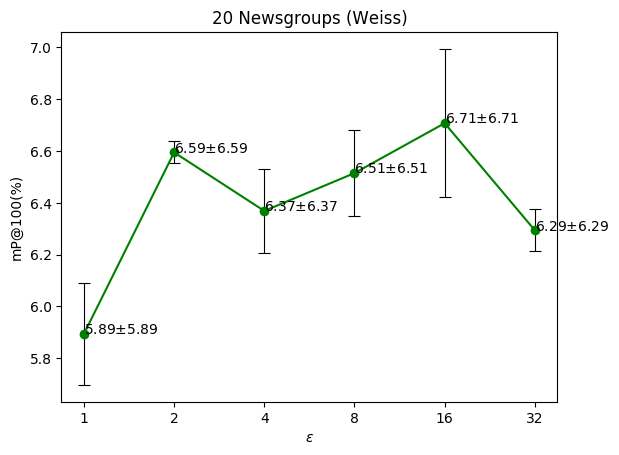

In [7]:
abscissa = sigma_parameters
ordinate = list(map(lambda x: x*100, precision_at_sigma_mean_16))
error = list(map(lambda x: x*100, precision_at_sigma_std_16))
 
plt.style.use('default') #seaborn-paper
plt.errorbar(abscissa, ordinate, error, capsize=4, capthick=0.8, ecolor='black', elinewidth=0.8, 
             marker = 'o', color='g', label=r'parametro $\epsilon$')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)

for i in range(len(ordinate)):
    # Create a formatted string with three spaces, one newline
    ann = r'{0:.2f}$\pm${0:.2f}'.format(ordinate[i], error[i])
    plt.annotate(ann, xy=(abscissa[i], ordinate[i]), xycoords='data')

plt.show()


#### 32 bits

In [8]:
import random
import copy
import math 

k = 100
sigma_parameters = [1, 2, 4, 8, 16, 32]
seeds = [1, 4 ,7]

precision_at_sigma_mean_32 = []
precision_at_sigma_std_32 = []

for sigma_parameter in sigma_parameters:
    print('Parametro epsilon {}'.format(sigma_parameter))
    hash_codes = binaryCodes(train_dataset, sigma=sigma_parameter, method = 'weiss')
    binary_codes = hash_codes.binary_codes(hash_len = 32)
    
    precision_val = []
    
    for count, seed in enumerate(seeds):
        print('    Conjunto de validacion {}'.format(count+1))
        random.seed(seed)
        
        validation_sample = random.sample(range(len(train_dataset['data'])), math.ceil(len(train_dataset['data'])*0.2))
        validation_split = {'binary_code': [], 'target': []}
        
        database = hashingDatabase()

        for index in range(len(train_dataset['data'])):
            if index in validation_sample:
                validation_split['binary_code'].append(binary_codes[index])
                validation_split['target'].append(train_dataset['target'][index])
            else:
                database.add_element(binary_codes[index], train_dataset['target'][index])

        precisions = []
        
        for index in range(len(validation_split['binary_code'])):
            precision = database.evaluate_P_K(validation_split['binary_code'][index], validation_split['target'][index], k)
            precisions.append(precision)    
            
        print("    --->Epsilon {} precision at {} mean precision {}".format(sigma_parameter, k, np.mean(precisions)))

        precision_val.append(np.mean(precisions))
    
    precision_at_sigma_mean_32.append(np.mean(precision_val))
    precision_at_sigma_std_32.append(np.std(precision_val))
    
    print("Global Mean Precision {} with std {}\n".format(np.mean(precision_val), np.std(precision_val)))

print("\n")
print("Mean: {}".format(precision_at_sigma_mean_32))
print("Std: {}".format( precision_at_sigma_std_32))

Parametro epsilon 1
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.8913639187812805 min
Nonzero elements count: 109056249
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.002893221378326416 min
Total Time: 6.146468794345855 min 

    Conjunto de validacion 1
    --->Epsilon 1 precision at 100 mean precision 0.07857348013403542
    Conjunto de validacion 2
    --->Epsilon 1 precision at 100 mean precision 0.07583532790809
    Conjunto de validacion 3
    --->Epsilon 1 precision at 100 mean precision 0.0786692197223552
Global Mean Precision 0.07769267592149354 with std 0.0013139248454822855

Parametro epsilon 2
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.862328553199768 min
Nonzero elements count: 109056249
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.0029971520105997723 min
Total Time: 6.074809300899505 min 

    Conjunto de validacion 1
    --->Epsilon 

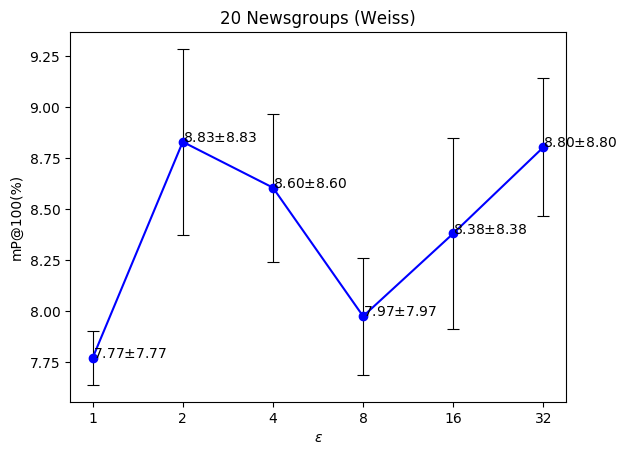

In [9]:
abscissa = sigma_parameters
ordinate = list(map(lambda x: x*100, precision_at_sigma_mean_32))
error = list(map(lambda x: x*100, precision_at_sigma_std_32))
 
plt.style.use('default') #seaborn-paper
plt.errorbar(abscissa, ordinate, error, capsize=4, capthick=0.8, ecolor='black', elinewidth=0.8, 
             marker = 'o', color='b', label=r'parametro $\epsilon$')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)

for i in range(len(ordinate)):
    # Create a formatted string with three spaces, one newline
    ann = r'{0:.2f}$\pm${0:.2f}'.format(ordinate[i], error[i])
    plt.annotate(ann, xy=(abscissa[i], ordinate[i]), xycoords='data')

plt.show()

#### 64 bits

In [10]:
import random
import copy
import math 

k = 100
sigma_parameters = [1, 2, 4, 8, 16, 32]
seeds = [1, 4 ,7]

precision_at_sigma_mean_64 = []
precision_at_sigma_std_64 = []

for sigma_parameter in sigma_parameters:
    print('Parametro epsilon {}'.format(sigma_parameter))
    hash_codes = binaryCodes(train_dataset, sigma=sigma_parameter, method = 'weiss')
    binary_codes = hash_codes.binary_codes(hash_len = 64)
    
    precision_val = []
    
    for count, seed in enumerate(seeds):
        print('    Conjunto de validacion {}'.format(count+1))
        random.seed(seed)
        
        validation_sample = random.sample(range(len(train_dataset['data'])), math.ceil(len(train_dataset['data'])*0.2))
        validation_split = {'binary_code': [], 'target': []}
        
        database = hashingDatabase()

        for index in range(len(train_dataset['data'])):
            if index in validation_sample:
                validation_split['binary_code'].append(binary_codes[index])
                validation_split['target'].append(train_dataset['target'][index])
            else:
                database.add_element(binary_codes[index], train_dataset['target'][index])

        precisions = []
        
        for index in range(len(validation_split['binary_code'])):
            precision = database.evaluate_P_K(validation_split['binary_code'][index], validation_split['target'][index], k)
            precisions.append(precision)    
            
        print("    --->Epsilon {} precision at {} mean precision {}".format(sigma_parameter, k, np.mean(precisions)))

        precision_val.append(np.mean(precisions))
    
    precision_at_sigma_mean_64.append(np.mean(precision_val))
    precision_at_sigma_std_64.append(np.std(precision_val))
    
    print("Global Mean Precision {} with std {}\n".format(np.mean(precision_val), np.std(precision_val)))

print("\n")
print("Mean: {}".format(precision_at_sigma_mean_64))
print("Std: {}".format( precision_at_sigma_std_64))

Parametro epsilon 1
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.8609391768773396 min
Nonzero elements count: 109056249
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.0029624104499816895 min
Total Time: 6.020425669352213 min 

    Conjunto de validacion 1
    --->Epsilon 1 precision at 100 mean precision 0.10295835327908091
    Conjunto de validacion 2
    --->Epsilon 1 precision at 100 mean precision 0.09932024892292964
    Conjunto de validacion 3
    --->Epsilon 1 precision at 100 mean precision 0.09740067017711823
Global Mean Precision 0.09989309079304293 with std 0.0023047879470899347

Parametro epsilon 2
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.409360921382904 min
Nonzero elements count: 109056249
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.002907466888427734 min
Total Time: 5.933978565533956 min 

    Conjunto de validacion 1
    --->Epsi

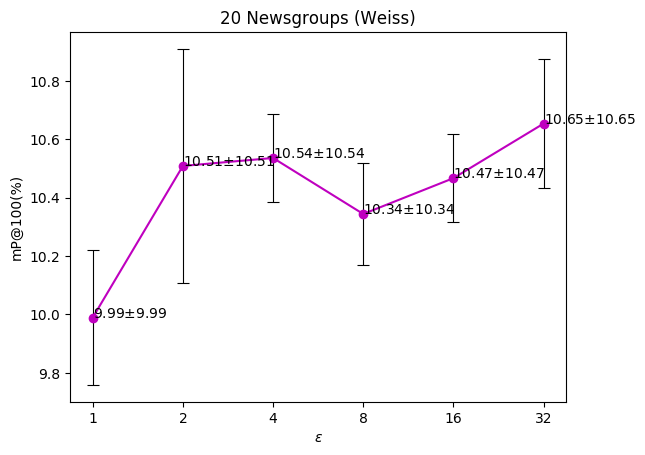

In [11]:
abscissa = sigma_parameters
ordinate = list(map(lambda x: x*100, precision_at_sigma_mean_64))
error = list(map(lambda x: x*100, precision_at_sigma_std_64))
 
plt.style.use('default') #seaborn-paper
plt.errorbar(abscissa, ordinate, error, capsize=4, capthick=0.8, ecolor='black', elinewidth=0.8, 
             marker = 'o', color='m', label=r'parametro $\epsilon$')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)

for i in range(len(ordinate)):
    # Create a formatted string with three spaces, one newline
    ann = r'{0:.2f}$\pm${0:.2f}'.format(ordinate[i], error[i])
    plt.annotate(ann, xy=(abscissa[i], ordinate[i]), xycoords='data')

plt.show()

### Comparación

In [12]:
precision_at_sigma_mean_16 = list(map(lambda x: x*100, precision_at_sigma_mean_16))
precision_at_sigma_mean_32 = list(map(lambda x: x*100, precision_at_sigma_mean_32))
precision_at_sigma_mean_64 = list(map(lambda x: x*100, precision_at_sigma_mean_64))

print(precision_at_sigma_mean_16)
print(precision_at_sigma_mean_32)
print(precision_at_sigma_mean_64)

[5.894367320887187, 6.594702409446305, 6.368756981011647, 6.514759853199298, 6.70735599170257, 6.2939205361416946]
[7.769267592149354, 8.828626136907612, 8.604276368278283, 7.9743098771341945, 8.38008616562949, 8.802936014041807]
[9.989309079304293, 10.508696345939047, 10.535982128610181, 10.344183820009574, 10.466890059039413, 10.653741822243497]


[5.894367320887187, 6.594702409446305, 6.368756981011647, 6.514759853199298, 6.70735599170257, 6.2939205361416946]
[7.769267592149354, 8.828626136907612, 8.604276368278283, 7.9743098771341945, 8.38008616562949, 8.802936014041807]
[9.989309079304293, 10.508696345939047, 10.535982128610181, 10.344183820009574, 10.466890059039413, 10.653741822243497]


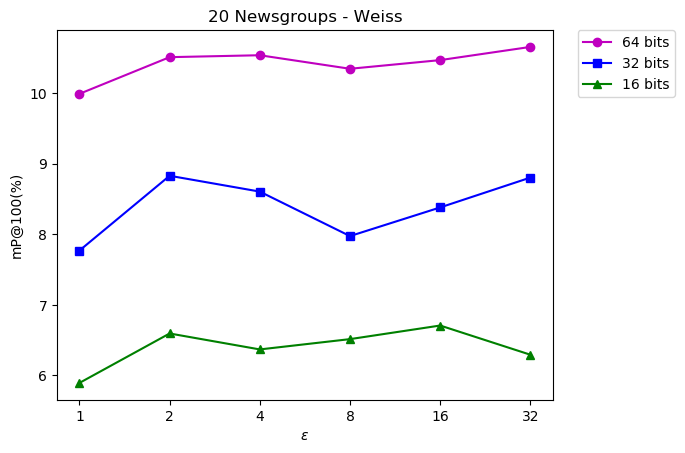

In [5]:
precision_at_sigma_mean_16 = [5.894367320887187, 6.594702409446305, 6.368756981011647, 6.514759853199298, 6.70735599170257, 6.2939205361416946]
precision_at_sigma_mean_32 = [7.769267592149354, 8.828626136907612, 8.604276368278283, 7.9743098771341945, 8.38008616562949, 8.802936014041807]
precision_at_sigma_mean_64 = [9.989309079304293, 10.508696345939047, 10.535982128610181, 10.344183820009574, 10.466890059039413, 10.653741822243497]

print(precision_at_sigma_mean_16)
print(precision_at_sigma_mean_32)
print(precision_at_sigma_mean_64)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sigma_parameters = [1, 2, 4, 8, 16, 32]

#### BORRAR LO DE ARRIBA ########################################


plt.style.use('default') #seaborn-paper
#print(plt.figure())

#print(plt.figure())
plt.plot(sigma_parameters, precision_at_sigma_mean_64, marker = 'o', color='m', label=r'64 bits')
plt.plot(sigma_parameters, precision_at_sigma_mean_32, marker = 's', color='b', label=r'32 bits')
plt.plot(sigma_parameters, precision_at_sigma_mean_16, marker = '^', color='g', label=r'16 bits')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups - Weiss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)
plt.savefig('newsgroups_weiss6.eps', format='eps', dpi=1000, bbox_inches='tight', fontsize='x-large')
plt.show()
#fontsize=14

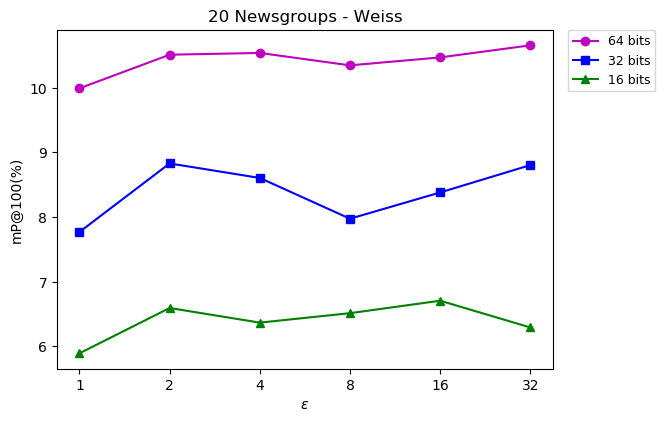

In [1]:
precision_at_sigma_mean_16 = [5.894367320887187, 6.594702409446305, 6.368756981011647, 6.514759853199298, 6.70735599170257, 6.2939205361416946]
precision_at_sigma_mean_32 = [7.769267592149354, 8.828626136907612, 8.604276368278283, 7.9743098771341945, 8.38008616562949, 8.802936014041807]
precision_at_sigma_mean_64 = [9.989309079304293, 10.508696345939047, 10.535982128610181, 10.344183820009574, 10.466890059039413, 10.653741822243497]

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sigma_parameters = [1, 2, 4, 8, 16, 32]

#### BORRAR LO DE ARRIBA ########################################


plt.style.use('default') #seaborn-paper
#print(plt.figure())
plt.figure(figsize=(6.4, 4.4))
#print(plt.figure())
plt.plot(sigma_parameters, precision_at_sigma_mean_64, marker = 'o', color='m', label=r'64 bits')
plt.plot(sigma_parameters, precision_at_sigma_mean_32, marker = 's', color='b', label=r'32 bits')
plt.plot(sigma_parameters, precision_at_sigma_mean_16, marker = '^', color='g', label=r'16 bits')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
plt.title('20 Newsgroups - Weiss')
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., fontsize=9)
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)
plt.savefig('newsgroups_weiss_newsgroup.eps', format='eps', dpi=1000, bbox_inches='tight', fontsize='x-large')
plt.show()
#fontsize=14

### SearchSnippets

In [13]:
dataset = Dataset()
print("Dataset structure:")
train_dataset = dataset.fetch_search_snippets(subset = 'train')
print(train_dataset.keys())
print("\n")
print("Dataset example:")
print(train_dataset['data'][0])
print("\n")
print("Train dataset:")
print("Set size: {}".format(len(train_dataset['data'])))
print("\n")

complete_dataset = train_dataset['data']

mean_length = sum(len(document.split()) for document in complete_dataset)/len(complete_dataset)
max_length = max(map(lambda document: len(document.split()), complete_dataset))

print('Mean Lenght: {}'.format(round(mean_length, 1)))
print('Max Lenght: {}'.format(max_length))
print("\n")

#vocabulary = list()
#for document in complete_dataset:
#    for word in document.split():
#        if word not in vocabulary:
#            vocabulary.append(word)
#
#print('Vocabulary Size: {}'.format(len(vocabulary)))

Dataset structure:
dict_keys(['target', 'data', 'target_names'])


Dataset example:
manufacture manufacturer directory directory china taiwan products manufacturers directory taiwan china products manufacturer direcory exporter directory supplier directory suppliers


Train dataset:
Set size: 10060


Mean Lenght: 18.1
Max Lenght: 50




### Weiss

#### Parametro $\epsilon$

#### 16 bits

In [14]:
import random
import copy
import math 

k = 100
sigma_parameters = [1, 2, 4, 8, 16, 32]
seeds = [1, 4 ,7]

precision_at_sigma_mean_16 = []
precision_at_sigma_std_16 = []

for sigma_parameter in sigma_parameters:
    print('Parametro epsilon {}'.format(sigma_parameter))
    hash_codes = binaryCodes(train_dataset, sigma=sigma_parameter, method = 'weiss')
    binary_codes = hash_codes.binary_codes(hash_len = 16)
    
    precision_val = []
    
    for count, seed in enumerate(seeds):
        print('    Conjunto de validacion {}'.format(count+1))
        random.seed(seed)
        
        validation_sample = random.sample(range(len(train_dataset['data'])), math.ceil(len(train_dataset['data'])*0.2))
        validation_split = {'binary_code': [], 'target': []}
        
        database = hashingDatabase()

        for index in range(len(train_dataset['data'])):
            if index in validation_sample:
                validation_split['binary_code'].append(binary_codes[index])
                validation_split['target'].append(train_dataset['target'][index])
            else:
                database.add_element(binary_codes[index], train_dataset['target'][index])

        precisions = []
        
        for index in range(len(validation_split['binary_code'])):
            precision = database.evaluate_P_K(validation_split['binary_code'][index], validation_split['target'][index], k)
            precisions.append(precision)    
            
        print("    --->Epsilon {} precision at {} mean precision {}".format(sigma_parameter, k, np.mean(precisions)))

        precision_val.append(np.mean(precisions))
    
    precision_at_sigma_mean_16.append(np.mean(precision_val))
    precision_at_sigma_std_16.append(np.std(precision_val))
    
    print("Global Mean Precision {} with std {}\n".format(np.mean(precision_val), np.std(precision_val)))

print("\n")
print("Mean: {}".format(precision_at_sigma_mean_16))
print("Std: {}".format( precision_at_sigma_std_16))

Parametro epsilon 1
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.3755408922831216 min
Nonzero elements count: 101203600
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.0028558174769083657 min
Total Time: 5.462110265096029 min 

    Conjunto de validacion 1
    --->Epsilon 1 precision at 100 mean precision 0.24866799204771375
    Conjunto de validacion 2
    --->Epsilon 1 precision at 100 mean precision 0.2525149105367793
    Conjunto de validacion 3
    --->Epsilon 1 precision at 100 mean precision 0.24933896620278329
Global Mean Precision 0.25017395626242545 with std 0.0016778163914553856

Parametro epsilon 2
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.501821994781494 min
Nonzero elements count: 101203600
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.002862103780110677 min
Total Time: 5.737407537301381 min 

    Conjunto de validacion 1
    --->Epsil

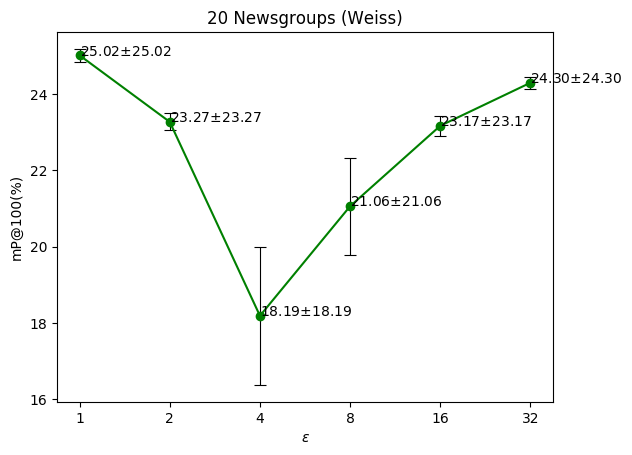

In [15]:
abscissa = sigma_parameters
ordinate = list(map(lambda x: x*100, precision_at_sigma_mean_16))
error = list(map(lambda x: x*100, precision_at_sigma_std_16))
 
plt.style.use('default') #seaborn-paper
plt.errorbar(abscissa, ordinate, error, capsize=4, capthick=0.8, ecolor='black', elinewidth=0.8, 
             marker = 'o', color='g', label=r'parametro $\epsilon$')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)

for i in range(len(ordinate)):
    # Create a formatted string with three spaces, one newline
    ann = r'{0:.2f}$\pm${0:.2f}'.format(ordinate[i], error[i])
    plt.annotate(ann, xy=(abscissa[i], ordinate[i]), xycoords='data')

plt.show()


#### 32 bits

In [16]:
import random
import copy
import math 

k = 100
sigma_parameters = [1, 2, 4, 8, 16, 32]
seeds = [1, 4 ,7]

precision_at_sigma_mean_32 = []
precision_at_sigma_std_32 = []

for sigma_parameter in sigma_parameters:
    print('Parametro epsilon {}'.format(sigma_parameter))
    hash_codes = binaryCodes(train_dataset, sigma=sigma_parameter, method = 'weiss')
    binary_codes = hash_codes.binary_codes(hash_len = 32)
    
    precision_val = []
    
    for count, seed in enumerate(seeds):
        print('    Conjunto de validacion {}'.format(count+1))
        random.seed(seed)
        
        validation_sample = random.sample(range(len(train_dataset['data'])), math.ceil(len(train_dataset['data'])*0.2))
        validation_split = {'binary_code': [], 'target': []}
        
        database = hashingDatabase()

        for index in range(len(train_dataset['data'])):
            if index in validation_sample:
                validation_split['binary_code'].append(binary_codes[index])
                validation_split['target'].append(train_dataset['target'][index])
            else:
                database.add_element(binary_codes[index], train_dataset['target'][index])

        precisions = []
        
        for index in range(len(validation_split['binary_code'])):
            precision = database.evaluate_P_K(validation_split['binary_code'][index], validation_split['target'][index], k)
            precisions.append(precision)    
            
        print("    --->Epsilon {} precision at {} mean precision {}".format(sigma_parameter, k, np.mean(precisions)))

        precision_val.append(np.mean(precisions))
    
    precision_at_sigma_mean_32.append(np.mean(precision_val))
    precision_at_sigma_std_32.append(np.std(precision_val))
    
    print("Global Mean Precision {} with std {}\n".format(np.mean(precision_val), np.std(precision_val)))

print("\n")
print("Mean: {}".format(precision_at_sigma_mean_32))
print("Std: {}".format( precision_at_sigma_std_32))

Parametro epsilon 1
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.229143420855204 min
Nonzero elements count: 101203600
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.0027387579282124835 min
Total Time: 5.356529724597931 min 

    Conjunto de validacion 1
    --->Epsilon 1 precision at 100 mean precision 0.28172465208747516
    Conjunto de validacion 2
    --->Epsilon 1 precision at 100 mean precision 0.2843489065606361
    Conjunto de validacion 3
    --->Epsilon 1 precision at 100 mean precision 0.28452286282306166
Global Mean Precision 0.283532140490391 with std 0.0012800588372715908

Parametro epsilon 2
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.4223576188087463 min
Nonzero elements count: 101203600
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.002815508842468262 min
Total Time: 5.773696370919546 min 

    Conjunto de validacion 1
    --->Epsilon

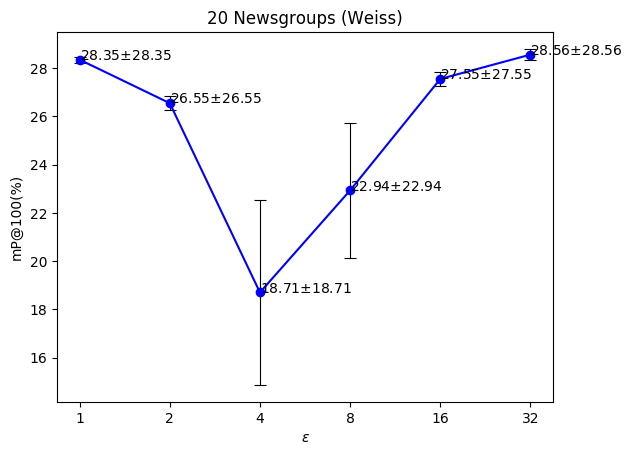

In [17]:
abscissa = sigma_parameters
ordinate = list(map(lambda x: x*100, precision_at_sigma_mean_32))
error = list(map(lambda x: x*100, precision_at_sigma_std_32))
 
plt.style.use('default') #seaborn-paper
plt.errorbar(abscissa, ordinate, error, capsize=4, capthick=0.8, ecolor='black', elinewidth=0.8, 
             marker = 'o', color='b', label=r'parametro $\epsilon$')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)

for i in range(len(ordinate)):
    # Create a formatted string with three spaces, one newline
    ann = r'{0:.2f}$\pm${0:.2f}'.format(ordinate[i], error[i])
    plt.annotate(ann, xy=(abscissa[i], ordinate[i]), xycoords='data')

plt.show()

#### 64 bits

In [18]:
import random
import copy
import math 

k = 100
sigma_parameters = [1, 2, 4, 8, 16, 32]
seeds = [1, 4 ,7]

precision_at_sigma_mean_64 = []
precision_at_sigma_std_64 = []

for sigma_parameter in sigma_parameters:
    print('Parametro epsilon {}'.format(sigma_parameter))
    hash_codes = binaryCodes(train_dataset, sigma=sigma_parameter, method = 'weiss')
    binary_codes = hash_codes.binary_codes(hash_len = 64)
    
    precision_val = []
    
    for count, seed in enumerate(seeds):
        print('    Conjunto de validacion {}'.format(count+1))
        random.seed(seed)
        
        validation_sample = random.sample(range(len(train_dataset['data'])), math.ceil(len(train_dataset['data'])*0.2))
        validation_split = {'binary_code': [], 'target': []}
        
        database = hashingDatabase()

        for index in range(len(train_dataset['data'])):
            if index in validation_sample:
                validation_split['binary_code'].append(binary_codes[index])
                validation_split['target'].append(train_dataset['target'][index])
            else:
                database.add_element(binary_codes[index], train_dataset['target'][index])

        precisions = []
        
        for index in range(len(validation_split['binary_code'])):
            precision = database.evaluate_P_K(validation_split['binary_code'][index], validation_split['target'][index], k)
            precisions.append(precision)    
            
        print("    --->Epsilon {} precision at {} mean precision {}".format(sigma_parameter, k, np.mean(precisions)))

        precision_val.append(np.mean(precisions))
    
    precision_at_sigma_mean_64.append(np.mean(precision_val))
    precision_at_sigma_std_64.append(np.std(precision_val))
    
    print("Global Mean Precision {} with std {}\n".format(np.mean(precision_val), np.std(precision_val)))

print("\n")
print("Mean: {}".format(precision_at_sigma_mean_64))
print("Std: {}".format( precision_at_sigma_std_64))

Parametro epsilon 1
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.1767075777053835 min
Nonzero elements count: 101203600
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.002856735388437907 min
Total Time: 5.370384605725606 min 

    Conjunto de validacion 1
    --->Epsilon 1 precision at 100 mean precision 0.3138568588469185
    Conjunto de validacion 2
    --->Epsilon 1 precision at 100 mean precision 0.317668986083499
    Conjunto de validacion 3
    --->Epsilon 1 precision at 100 mean precision 0.3094234592445328
Global Mean Precision 0.3136497680583168 with std 0.0033694057991551845

Parametro epsilon 2
Calculating hash codes
Calculating W matrix using weiss method ...
Time to compute: 3.3293267687161765 min
Nonzero elements count: 101203600
Ratio: 1.0
Calculating D matrix using weiss method ...
Time to compute: 0.0029214938481648763 min
Total Time: 5.396512575944265 min 

    Conjunto de validacion 1
    --->Epsilon 

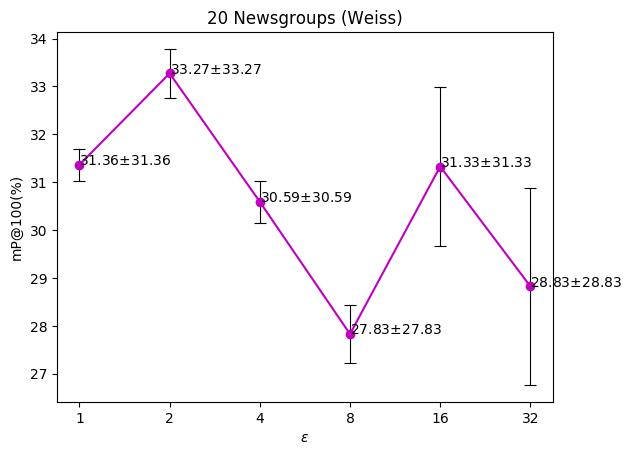

In [19]:
abscissa = sigma_parameters
ordinate = list(map(lambda x: x*100, precision_at_sigma_mean_64))
error = list(map(lambda x: x*100, precision_at_sigma_std_64))
 
plt.style.use('default') #seaborn-paper
plt.errorbar(abscissa, ordinate, error, capsize=4, capthick=0.8, ecolor='black', elinewidth=0.8, 
             marker = 'o', color='m', label=r'parametro $\epsilon$')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)

for i in range(len(ordinate)):
    # Create a formatted string with three spaces, one newline
    ann = r'{0:.2f}$\pm${0:.2f}'.format(ordinate[i], error[i])
    plt.annotate(ann, xy=(abscissa[i], ordinate[i]), xycoords='data')

plt.show()

### Comparación

In [20]:
print(list(map(lambda x: x*100, precision_at_sigma_mean_16)))
print(list(map(lambda x: x*100, precision_at_sigma_mean_32)))
print(list(map(lambda x: x*100, precision_at_sigma_mean_64)))

[25.017395626242546, 23.27170311464546, 18.187872763419485, 21.061133200795226, 23.1708084824387, 24.29870775347913]
[28.3532140490391, 26.549536116633533, 18.706262425447314, 22.93538767395626, 27.55351225977469, 28.561464546056985]
[31.36497680583168, 33.27186878727634, 30.590954274353884, 27.829688535453943, 31.327534791252486, 28.82620941020544]


[25.017395626242546, 23.27170311464546, 18.187872763419485, 21.061133200795226, 23.1708084824387, 24.29870775347913]
[28.3532140490391, 26.549536116633533, 18.706262425447314, 22.93538767395626, 27.55351225977469, 28.561464546056985]
[31.36497680583168, 33.27186878727634, 30.590954274353884, 27.829688535453943, 31.327534791252486, 28.82620941020544]


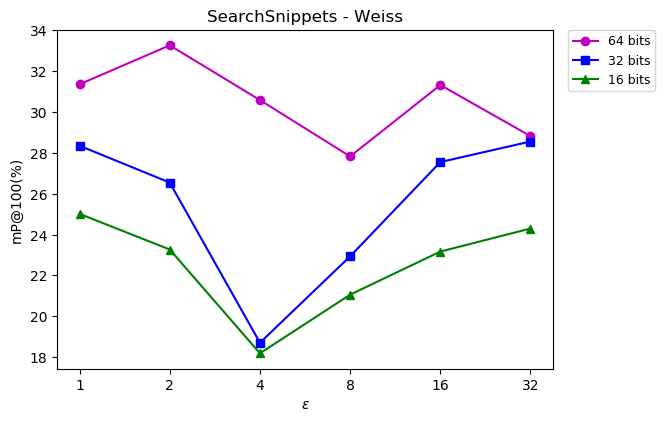

In [2]:
precision_at_sigma_mean_16 = [25.017395626242546, 23.27170311464546, 18.187872763419485, 21.061133200795226, 23.1708084824387, 24.29870775347913]
precision_at_sigma_mean_32 = [28.3532140490391, 26.549536116633533, 18.706262425447314, 22.93538767395626, 27.55351225977469, 28.561464546056985]
precision_at_sigma_mean_64 = [31.36497680583168, 33.27186878727634, 30.590954274353884, 27.829688535453943, 31.327534791252486, 28.82620941020544]

print(precision_at_sigma_mean_16)
print(precision_at_sigma_mean_32)
print(precision_at_sigma_mean_64)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sigma_parameters = [1, 2, 4, 8, 16, 32]

#### BORRAR LO DE ARRIBA ########################################


plt.style.use('default') #seaborn-paper
#print(plt.figure())
plt.figure(figsize=(6.4, 4.4))
#print(plt.figure())
plt.plot(sigma_parameters, precision_at_sigma_mean_64, marker = 'o', color='m', label=r'64 bits')
plt.plot(sigma_parameters, precision_at_sigma_mean_32, marker = 's', color='b', label=r'32 bits')
plt.plot(sigma_parameters, precision_at_sigma_mean_16, marker = '^', color='g', label=r'16 bits')
plt.xscale('log', basex=2)
plt.xticks(sigma_parameters, sigma_parameters)
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
plt.title('SearchSnippets - Weiss')
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., fontsize=9)
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)
plt.savefig('newsgroups_weiss_searchsnippetsp.eps', format='eps', dpi=1000, bbox_inches='tight', fontsize='x-large')
plt.show()

In [ ]:
################################################

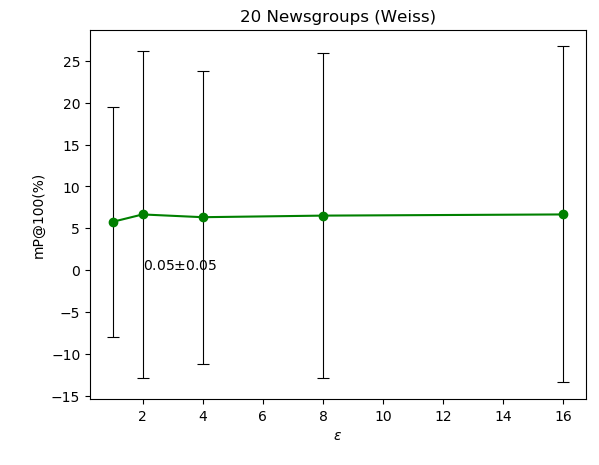

In [18]:
plt.style.use('default') #seaborn-paper
plt.errorbar(sigma_parameters, list(map(lambda x: x*100, precision_at_sigma_mean)), 
             list(map(lambda x: x*100, precision_at_sigma_std)), capsize=4, capthick=0.8, ecolor='black', elinewidth=0.8, 
             marker = 'o', color='g', label=r'parametro $\epsilon$')
#plt.xscale('log')
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)

for i in range(len(ordenadas)):
    # Create a formatted string with three spaces, one newline
    ann = r'{0:.2f}$\pm${0:.2f}'.format(ordenadas[i], error[i])
    plt.annotate(ann, xy=(absisas[i], ordenadas[i]))

plt.show()

In [ ]:
      #evaluate.intra_cluster_distance(binary_codes, train_dataset)
        #evaluate.inter_cluster_distance(binary_codes, train_dataset)

In [6]:
import random
import copy
import math 

sigma_parameters = [1, 2, 4, 8, 16]
precision_at_sigma = []

random.seed(7)

for sigma_parameter in sigma_parameters:
    hash_codes = binaryCodes(train_dataset, sigma=sigma_parameter, method = 'weiss')
    binary_codes = hash_codes.binary_codes(hash_len = 16)

    #evaluate.intra_cluster_distance(binary_codes, train_dataset)
    #evaluate.inter_cluster_distance(binary_codes, train_dataset)

    validation_sample = random.sample(range(len(train_dataset['data'])), math.ceil(len(train_dataset['data'])*0.2))

    database = hashingDatabase()

    validation_split = {'binary_code': [], 'target': []}

    for index in range(len(train_dataset['data'])):
        if index in validation_sample:
            validation_split['binary_code'].append(binary_codes[index])
            validation_split['target'].append(train_dataset['target'][index])
        else:
            database.add_element(binary_codes[index], train_dataset['target'][index])

    k = 100    
    precisions = []

    for index in range(len(validation_split['binary_code'])):
        precision = database.evaluate_P_K(validation_split['binary_code'][index], validation_split['target'][index], k)
        precisions.append(precision)    

    print("precision at {}".format(k))
    print('Mean Precision')
    print(np.mean(precisions))
    
    precision_at_sigma.append(np.mean(precisions))
    
print(precision_at_sigma)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Preexist hash codes
Time to compute: 29.087435205777485 min
precision at 100
Mean Precision
0.07814265198659646
Preexist hash codes
Time to compute: 30.117789081732433 min
precision at 100
Mean Precision
0.08671613212063188
Preexist hash codes
Time to compute: 28.150322564442952 min
precision at 100
Mean Precision
0.08715653422690282
Preexist hash codes
Time to compute: 17.143831650416057 min
precision at 100
Mean Precision
0.08322163714696028
Preexist hash codes
Time to compute: 17.697351253032686 min
precision at 100
Mean Precision
0.0803350885591192
[0.07814265198659646, 0.08671613212063188, 0.08715653422690282, 0.08322163714696028, 0.0803350885591192]


In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import Image, display

plt.style.use('seaborn-paper')
plt.plot(sigma_parameters, list(map(lambda x: x*100, precision_at_sigma)), marker = 'o', color='g', label=r'parametro $\epsilon$')
#plt.xscale('log')
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
plt.rc('grid', linestyle=":", color='grey')
plt.grid(True)
plt.show()

NameError: name 'sigma_parameters' is not defined

In [ ]:
[0.07814265198659646, 0.08671613212063188, 0.08715653422690282, 0.08322163714696028, 0.0803350885591192]

In [14]:
print(str(0.01).replace('.', ''))

001


In [ ]:
import random
import copy
import math 

tiny_train_dataset = {'data': [], 'target': [], 'target_names': train_dataset['target_names']}

random.seed(7)
actual_num_samples = len(train_dataset['data'])
print(actual_num_samples)

for _ in range(0, 100):
    selected_index = random.randint(0, actual_num_samples-1)
        
    selected_document = train_dataset['data'][selected_index]
    selected_target =  train_dataset['target'][selected_index]
    
    tiny_train_dataset['data'].append(selected_document)
    tiny_train_dataset['target'].append(selected_target)

    del train_dataset['data'][selected_index]
    del train_dataset['target'][selected_index]
    
    actual_num_samples -= 1
    
print(len(train_dataset['data']))
print(len(train_dataset['target']))

print(len(tiny_train_dataset['data']))
print(len(tiny_train_dataset['target']))

print(tiny_train_dataset['target'])

In [ ]:

tiny_train_dataset = train_dataset

In [ ]:
k = 100
precisions = []

for i in range(len(glove_em_test)):
    example = np.asarray(glove_em_test[i])
    #print(example.shape)
    example = example.reshape((1, example.shape[0], example.shape[1]))
    #print(example.shape)
    #break
    hash_code = predict_hash_code(example).reshape((1, len_hash))
    #print(hash_code)
    #print(tiny_test_dataset['target'][i])
    #print('Precision')
    #print('hash: {}'.format(hash_code));
    #print('target: {}'.format(tiny_test_dataset['target'][i]))
    precision = database.evaluate_P_K(hash_code, tiny_test_dataset['target'][i], k)
    #print(precision)
    #print('\n')
    precisions.append(precision)
    
#print(precisions)
print("precision at {}".format(k))
print('Mean Precision')
print(np.mean(precisions))

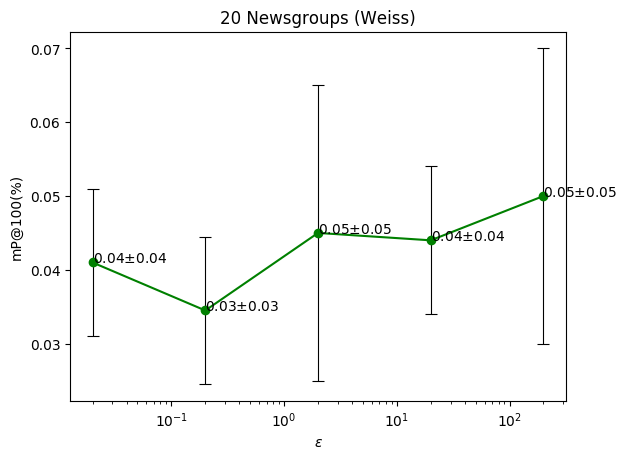

In [5]:
ordenadas = [0.041, 0.0345, 0.045000000000000005, 0.044000000000000004, 0.05000000000000001]
absisas = [0.02, 0.2, 2, 20, 200]
error = [0.01, 0.01, 0.02, 0.01, 0.02]

plt.style.use('default') #seaborn-paper
plt.errorbar(absisas, ordenadas, error, capsize=4, capthick=0.8, ecolor='black', elinewidth=0.8, 
             marker = 'o', color='g', label=r'parametro $\epsilon$')
plt.xscale('log')
plt.xlabel(r'$\epsilon$')
plt.ylabel('mP@100(%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('20 Newsgroups (Weiss)')
#plt.rc('grid', linestyle=":", color='grey')
#plt.grid(True)

for i in range(len(ordenadas)):
    # Create a formatted string with three spaces, one newline
    ann = r'{0:.2f}$\pm${0:.2f}'.format(ordenadas[i], error[i])
    plt.annotate(ann, xy=(absisas[i], ordenadas[i]))

plt.show()


#### Wang

In [ ]:
import random
import copy
import math 

sigma_parameters = [1, 2, 5, 10, 25]
precision_at_sigma = []

random.seed(7)

for sigma_parameter in sigma_parameters:
    hash_codes = binaryCodes(train_dataset, sigma=sigma_parameter, method = 'chinese_weiss')
    binary_codes = hash_codes.binary_codes(hash_len = 32)

    #evaluate.intra_cluster_distance(binary_codes, train_dataset)
    #evaluate.inter_cluster_distance(binary_codes, train_dataset)

    validation_sample = random.sample(range(len(train_dataset['data'])), math.ceil(len(train_dataset['data'])*0.2))

    database = hashingDatabase()

    validation_split = {'binary_code': [], 'target': []}

    for index in range(len(train_dataset['data'])):
        if index in validation_sample:
            validation_split['binary_code'].append(binary_codes[index])
            validation_split['target'].append(train_dataset['target'][index])
        else:
            database.add_element(binary_codes[index], train_dataset['target'][index])

    k = 100    
    precisions = []

    for index in range(len(validation_split['binary_code'])):
        precision = database.evaluate_P_K(validation_split['binary_code'][index], validation_split['target'][index], k)
        precisions.append(precision)    

    print("precision at {}".format(k))
    print('Mean Precision')
    print(np.mean(precisions))
    
    precision_at_sigma.append(np.mean(precisions))
    
print(precision_at_sigma)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Calculated hash codes
Not preexist W matrix
Calculated using chinese_weiss method ...
Time to compute: 731.5848241686821 min
Nonzero elements count: 106142
Ratio: 0.0009732775606467081
Calculated D matrix
Time to compute: 0.006510492165883382 min
Time to compute: 17.310988636811576 min
precision at 100
Mean Precision
0.5616179990426041
Calculated hash codes
Not preexist W matrix
Calculated using chinese_weiss method ...


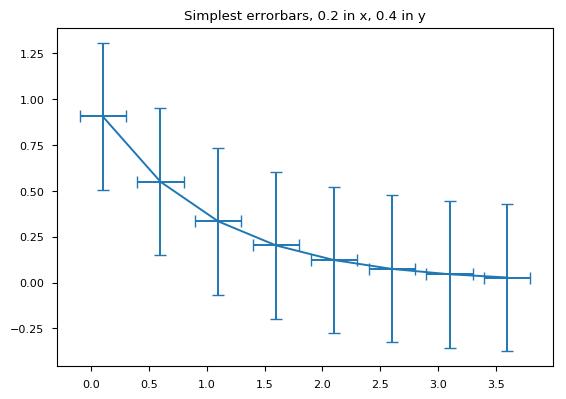

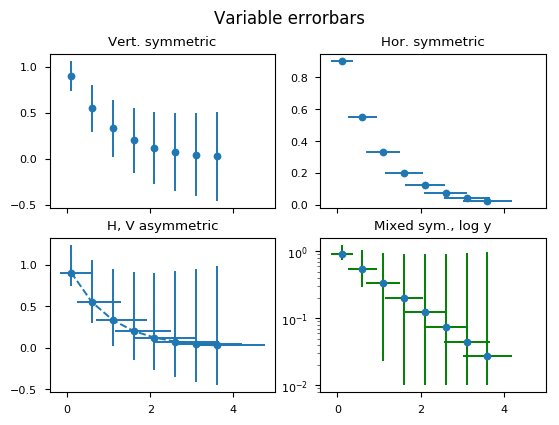

In [18]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')


# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example variable error bar values
yerr = 0.1 + 0.2*np.sqrt(x)
xerr = 0.1 + yerr

# First illustrate basic pyplot interface, using defaults where possible.
plt.figure()
plt.errorbar(x, y, xerr=0.2, yerr=0.4, capsize=4, capthick=1)
plt.title("Simplest errorbars, 0.2 in x, 0.4 in y")

# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
ax = axs[0,0]
ax.errorbar(x, y, yerr=yerr, fmt='o')
ax.set_title('Vert. symmetric')

# With 4 subplots, reduce the number of axis ticks to avoid crowding.
ax.locator_params(nbins=4)

ax = axs[0,1]
ax.errorbar(x, y, xerr=xerr, fmt='o')
ax.set_title('Hor. symmetric')

ax = axs[1,0]
ax.errorbar(x, y, yerr=[yerr, 2*yerr], xerr=[xerr, 2*xerr], fmt='--o')
ax.set_title('H, V asymmetric')

ax = axs[1,1]
ax.set_yscale('log')
# Here we have to be careful to keep all y values positive:
ylower = np.maximum(1e-2, y - yerr)
yerr_lower = y - ylower

ax.errorbar(x, y, yerr=[yerr_lower, 2*yerr], xerr=xerr,
            fmt='o', ecolor='g', capthick=2)
ax.set_title('Mixed sym., log y')

fig.suptitle('Variable errorbars')

plt.show()

NameError: name 'num' is not defined

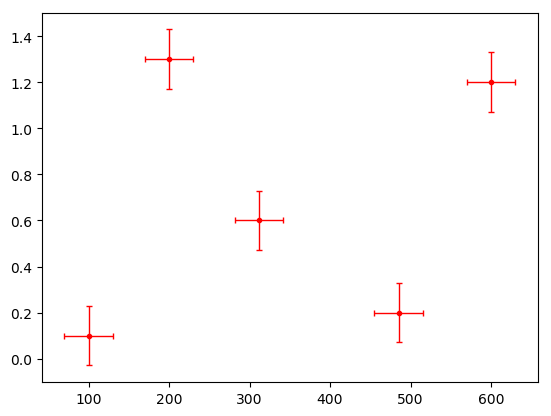

In [83]:
import numpy as np
import matplotlib.pyplot as plt

#  Made up data
x = np.array([ 312, 485, 100, 600, 200])
y = np.array([ .6, .2, .1, 1.2, 1.3 ])
xerr = x.max()/20
yerr = y.max()/10

plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.', color='red', elinewidth=1, capsize=2)

for i,j in enumerate(num):
    # Create a formatted string with three spaces, one newline
    ann = '   {}\n'.format(j)
    plt.annotate(ann, xy=(x[i],y[i]))

AttributeError: 'str' object has no attribute 'values'

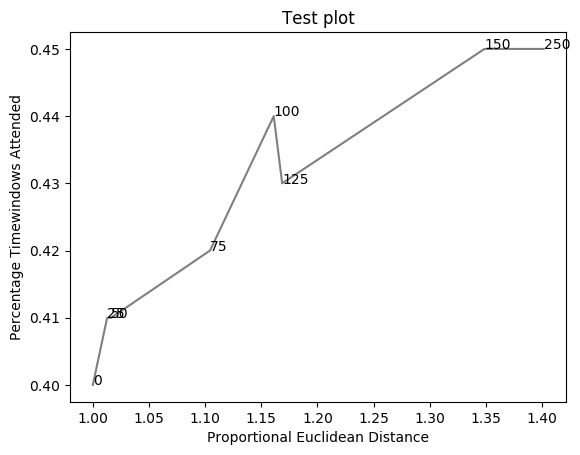

In [97]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np
together = [(0, 1.0, 0.4), (25, 1.0127692669427917, 0.41), (50, 1.016404709797609, 0.41), (75, 1.1043426359673716, 0.42), (100, 1.1610446924342996, 0.44), (125, 1.1685687930691457, 0.43), (150, 1.3486407784550272, 0.45), (250, 1.4013999168008104, 0.45)]
together.sort()

text = [x for (x,y,z) in together]
eucs = [y for (x,y,z) in together]
covers = [z for (x,y,z) in together]

p1 = plt.plot(eucs,covers,color="black", alpha=0.5)
texts = []
for x, y, s in zip(eucs, covers, text):
    texts.append(plt.text(x, y, s))

plt.xlabel("Proportional Euclidean Distance")
plt.ylabel("Percentage Timewindows Attended")
plt.title("Test plot")
adjust_text(texts, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.show()